<a href="https://colab.research.google.com/github/PotatoSpudowski/CactiNet/blob/master/Aerial_Cactus_Identification_using_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install kaggle

In [0]:
from google.colab import files
# files.upload()
#Upload the kaggle.json file here

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c aerial-cactus-identification

  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 61.2MB/s]
  0% 0.00/4.20M [00:00<?, ?B/s]
100% 4.20M/4.20M [00:00<00:00, 68.9MB/s]
  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 193MB/s]
 47% 9.00M/19.2M [00:00<00:00, 56.1MB/s]
100% 19.2M/19.2M [00:00<00:00, 94.2MB/s]


In [9]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.zip  train.csv  train.zip


In [0]:
# !unzip train.zip
# !unzip test.zip
# !ls

In [7]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.5.1-cp36-none-any.whl size=11768 sha256=b66828c16465a21514f78f3b99d833c05306dab2f291138ba2ea90186bd8f1bf
  Stored in directory: /root/.cache/pip/wheels/52/0c/8e/58d91f29f0f8cbb45231a145312939a5423dc82c61cc731361
Successfully built efficientnet-pytorch


In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchsummary import summary
from efficientnet_pytorch import EfficientNet

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [0]:
train = './train'
test = './test'

train_labels =  pd.read_csv('./train.csv')

In [237]:
train_labels.head(10)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1
6,002134abf28af54575c18741b89dd2a4.jpg,0
7,0024320f43bdd490562246435af4f90b.jpg,0
8,002930423b9840e67e5a54afd4768a1e.jpg,1
9,00351838ebf6dff6e53056e00a1e307c.jpg,1


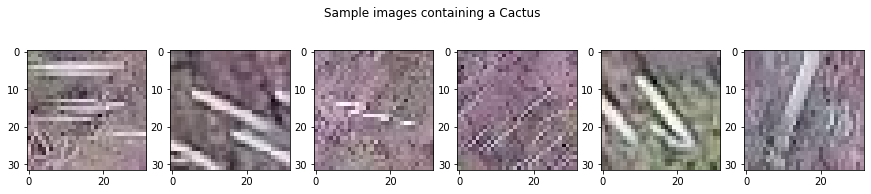

In [13]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6,figsize=(15,3))
fig.suptitle('Sample images containing a Cactus')
ax1.imshow(mpimg.imread(train+'/'+train_labels['id'][0]))
ax2.imshow(mpimg.imread(train+'/'+train_labels['id'][1]))
ax3.imshow(mpimg.imread(train+'/'+train_labels['id'][2]))
ax4.imshow(mpimg.imread(train+'/'+train_labels['id'][3]))
ax5.imshow(mpimg.imread(train+'/'+train_labels['id'][4]))
ax6.imshow(mpimg.imread(train+'/'+train_labels['id'][5]))

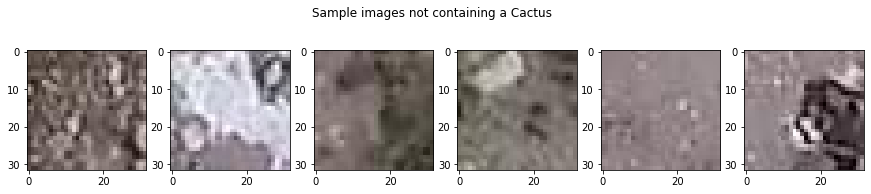

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6,figsize=(15,3))
fig.suptitle('Sample images not containing a Cactus')
ax1.imshow(mpimg.imread(train+'/'+train_labels['id'][6]))
ax2.imshow(mpimg.imread(train+'/'+train_labels['id'][7]))
ax3.imshow(mpimg.imread(train+'/'+train_labels['id'][11]))
ax4.imshow(mpimg.imread(train+'/'+train_labels['id'][14]))
ax5.imshow(mpimg.imread(train+'/'+train_labels['id'][16]))
ax6.imshow(mpimg.imread(train+'/'+train_labels['id'][17]))

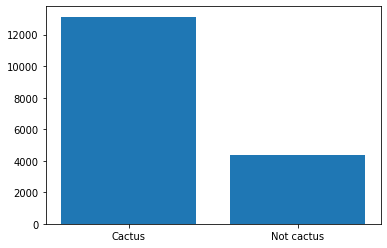

In [15]:
no_of_samples = [len(train_labels[train_labels['has_cactus'] == 1]), len(train_labels[train_labels['has_cactus'] == 0])]
plot_labels = ('Cactus', 'Not cactus')
y_pos = np.arange(len(no_of_samples))
plt.bar(y_pos, no_of_samples)
plt.xticks(y_pos, plot_labels)
plt.show()

In [0]:
class Data(Dataset):
    def __init__(self, df, data_dir, transform):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name = self.df.id[index]
        label = self.df.has_cactus[index]

        img_path = os.path.join(self.data_dir, img_name)
        img = mpimg.imread(img_path)
        img = self.transform(img)
        return img, label

In [0]:
data_transf = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
train_data = Data(df = train_labels, data_dir = train, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size = 64)

##Trying Efficientnet-b3

In [0]:
model = EfficientNet.from_name('efficientnet-b3')

In [0]:
for param in model.parameters():
    param.requires_grad = True

In [0]:
model._fc = nn.Linear(model._fc.in_features, 1)

In [0]:
model = model.to('cuda')

In [161]:
summary(model, (3, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 3, 41, 41]               0
Conv2dStaticSamePadding-2           [-1, 40, 20, 20]           1,080
       BatchNorm2d-3           [-1, 40, 20, 20]              80
MemoryEfficientSwish-4           [-1, 40, 20, 20]               0
         ZeroPad2d-5           [-1, 40, 22, 22]               0
Conv2dStaticSamePadding-6           [-1, 40, 20, 20]             360
       BatchNorm2d-7           [-1, 40, 20, 20]              80
MemoryEfficientSwish-8           [-1, 40, 20, 20]               0
          Identity-9             [-1, 40, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 10, 1, 1]             410
MemoryEfficientSwish-11             [-1, 10, 1, 1]               0
         Identity-12             [-1, 10, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 40, 1, 1]             440
         I

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.BCELoss()

In [163]:
%%time
loss_log = []
val_loss_log = []
n_epochs = 15

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)

    model.train()
    for step, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        target = target.float()

        optimizer.zero_grad()
        output = model(data)

        m = nn.Sigmoid()
        loss = loss_func(m(output), target)
        loss.backward()

        optimizer.step()

        if step % 10 == 0:
            loss_log.append(loss.item())      

    print('Epoch: {} - Loss: {}'.format(epoch+1, loss.item()))

Epoch 0/14
----------
Epoch: 1 - Loss: 0.29714468121528625
Epoch 1/14
----------
Epoch: 2 - Loss: 0.28154242038726807
Epoch 2/14
----------
Epoch: 3 - Loss: 0.15398046374320984
Epoch 3/14
----------
Epoch: 4 - Loss: 0.04002682492136955
Epoch 4/14
----------
Epoch: 5 - Loss: 0.024564700201153755
Epoch 5/14
----------
Epoch: 6 - Loss: 0.0058298599906265736
Epoch 6/14
----------
Epoch: 7 - Loss: 0.02711106464266777
Epoch 7/14
----------
Epoch: 8 - Loss: 0.09920398890972137
Epoch 8/14
----------
Epoch: 9 - Loss: 0.005807966459542513
Epoch 9/14
----------
Epoch: 10 - Loss: 0.0019751929212361574
Epoch 10/14
----------
Epoch: 11 - Loss: 0.00016393921396229416
Epoch 11/14
----------
Epoch: 12 - Loss: 0.035245537757873535
Epoch 12/14
----------
Epoch: 13 - Loss: 0.04602671042084694
Epoch 13/14
----------
Epoch: 14 - Loss: 0.0014576077228412032
Epoch 14/14
----------
Epoch: 15 - Loss: 0.0015870200004428625
CPU times: user 8min 36s, sys: 27.9 s, total: 9min 4s
Wall time: 9min 5s


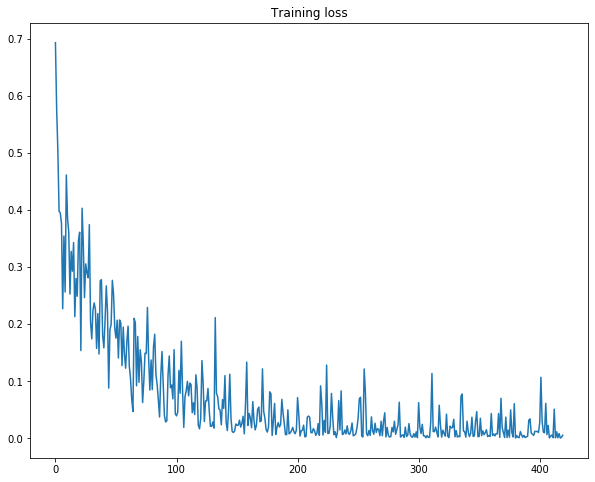

In [164]:
plt.figure(figsize=(10,8))
plt.title('Training loss')
plt.plot(loss_log)

In [0]:
submit = pd.read_csv('./sample_submission.csv')
test_data = Data(df = submit, data_dir = test, transform = data_transf) 
test_loader = DataLoader(dataset = test_data, shuffle=False)

In [166]:
%%time
predictions = []
model.eval()
for i, (data, _) in enumerate(test_loader):
    data = data.cuda()
    output = model(data)

    pred = torch.sigmoid(output)
    predictions.append(pred.item())

CPU times: user 1min 16s, sys: 96.4 ms, total: 1min 16s
Wall time: 1min 16s


In [0]:
submit['has_cactus'] = predictions
submit.to_csv('submission1.csv', index=False)

In [168]:
!ls

kaggle.json  sample_submission.csv  test      train	 train.zip
sample_data  submission1.csv	    test.zip  train.csv


In [0]:
files.download('./submission1.csv')

##Trying Efficientnet-b1

In [170]:
model = EfficientNet.from_name('efficientnet-b1')

for param in model.parameters():
    param.requires_grad = True

model._fc = nn.Linear(model._fc.in_features, 1)

model = model.to('cuda')

summary(model, (3, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 3, 41, 41]               0
Conv2dStaticSamePadding-2           [-1, 32, 20, 20]             864
       BatchNorm2d-3           [-1, 32, 20, 20]              64
MemoryEfficientSwish-4           [-1, 32, 20, 20]               0
         ZeroPad2d-5           [-1, 32, 22, 22]               0
Conv2dStaticSamePadding-6           [-1, 32, 20, 20]             288
       BatchNorm2d-7           [-1, 32, 20, 20]              64
MemoryEfficientSwish-8           [-1, 32, 20, 20]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.BCELoss()

In [172]:
%%time
loss_log = []
val_loss_log = []
n_epochs = 10

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)

    model.train()
    for step, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        target = target.float()

        optimizer.zero_grad()
        output = model(data)

        m = nn.Sigmoid()
        loss = loss_func(m(output), target)
        loss.backward()

        optimizer.step()

        if step % 10 == 0:
            loss_log.append(loss.item())      

    print('Epoch: {} - Loss: {}'.format(epoch+1, loss.item()))

Epoch 0/9
----------
Epoch: 1 - Loss: 0.4220370352268219
Epoch 1/9
----------
Epoch: 2 - Loss: 0.2862281799316406
Epoch 2/9
----------
Epoch: 3 - Loss: 0.16285398602485657
Epoch 3/9
----------
Epoch: 4 - Loss: 0.1456364244222641
Epoch 4/9
----------
Epoch: 5 - Loss: 0.08422636985778809
Epoch 5/9
----------
Epoch: 6 - Loss: 0.3086318075656891
Epoch 6/9
----------
Epoch: 7 - Loss: 0.012001005932688713
Epoch 7/9
----------
Epoch: 8 - Loss: 0.004346102941781282
Epoch 8/9
----------
Epoch: 9 - Loss: 0.034796979278326035
Epoch 9/9
----------
Epoch: 10 - Loss: 0.0032742086332291365
CPU times: user 5min 2s, sys: 8.51 s, total: 5min 10s
Wall time: 5min 11s


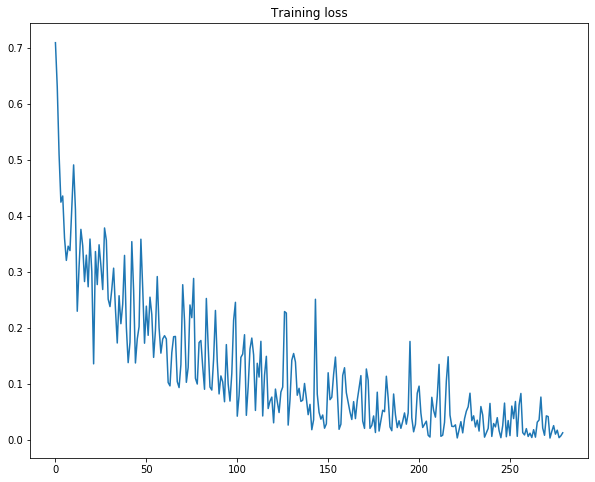

In [173]:
plt.figure(figsize=(10,8))
plt.title('Training loss')
plt.plot(loss_log)

In [0]:
submit = pd.read_csv('./sample_submission.csv')
test_data = Data(df = submit, data_dir = test, transform = data_transf) 
test_loader = DataLoader(dataset = test_data, shuffle=False)

In [175]:
%%time
predictions = []
model.eval()
for i, (data, _) in enumerate(test_loader):
    data = data.cuda()
    output = model(data)

    pred = torch.sigmoid(output)
    predictions.append(pred.item())

CPU times: user 1min 9s, sys: 102 ms, total: 1min 9s
Wall time: 1min 9s


In [0]:
submit['has_cactus'] = predictions
submit.to_csv('submission1.csv', index=False)

In [0]:
files.download('./submission1.csv')

##Trying Efficentnet-b2

In [178]:
model = EfficientNet.from_name('efficientnet-b2')

for param in model.parameters():
    param.requires_grad = True

model._fc = nn.Linear(model._fc.in_features, 1)

model = model.to('cuda')

summary(model, (3, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 3, 41, 41]               0
Conv2dStaticSamePadding-2           [-1, 32, 20, 20]             864
       BatchNorm2d-3           [-1, 32, 20, 20]              64
MemoryEfficientSwish-4           [-1, 32, 20, 20]               0
         ZeroPad2d-5           [-1, 32, 22, 22]               0
Conv2dStaticSamePadding-6           [-1, 32, 20, 20]             288
       BatchNorm2d-7           [-1, 32, 20, 20]              64
MemoryEfficientSwish-8           [-1, 32, 20, 20]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.BCELoss()

In [180]:
%%time
loss_log = []
val_loss_log = []
n_epochs = 12

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)

    model.train()
    for step, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        target = target.float()

        optimizer.zero_grad()
        output = model(data)

        m = nn.Sigmoid()
        loss = loss_func(m(output), target)
        loss.backward()

        optimizer.step()

        if step % 10 == 0:
            loss_log.append(loss.item())      

    print('Epoch: {} - Loss: {}'.format(epoch+1, loss.item()))

Epoch 0/11
----------
Epoch: 1 - Loss: 0.31098541617393494
Epoch 1/11
----------
Epoch: 2 - Loss: 0.3839412331581116
Epoch 2/11
----------
Epoch: 3 - Loss: 0.17809449136257172
Epoch 3/11
----------
Epoch: 4 - Loss: 0.06512243300676346
Epoch 4/11
----------
Epoch: 5 - Loss: 0.15560804307460785
Epoch 5/11
----------
Epoch: 6 - Loss: 0.008201895281672478
Epoch 6/11
----------
Epoch: 7 - Loss: 0.032548077404499054
Epoch 7/11
----------
Epoch: 8 - Loss: 0.016096079722046852
Epoch 8/11
----------
Epoch: 9 - Loss: 0.0012614335864782333
Epoch 9/11
----------
Epoch: 10 - Loss: 0.0011721010087057948
Epoch 10/11
----------
Epoch: 11 - Loss: 0.003713973332196474
Epoch 11/11
----------
Epoch: 12 - Loss: 0.1395578533411026
CPU times: user 6min 4s, sys: 11.9 s, total: 6min 16s
Wall time: 6min 17s


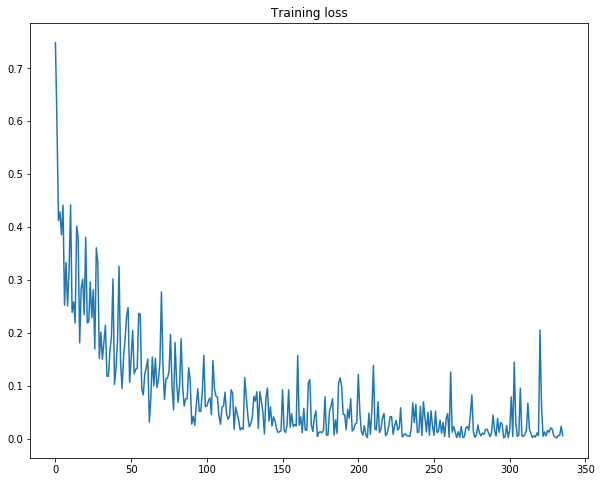

In [181]:
plt.figure(figsize=(10,8))
plt.title('Training loss')
plt.plot(loss_log)

In [182]:
%%time
predictions = []
model.eval()
for i, (data, _) in enumerate(test_loader):
    data = data.cuda()
    output = model(data)

    pred = torch.sigmoid(output)
    predictions.append(pred.item())

CPU times: user 1min 8s, sys: 110 ms, total: 1min 8s
Wall time: 1min 8s


In [0]:
submit['has_cactus'] = predictions
submit.to_csv('submission1.csv', index=False)

In [0]:
files.download('./submission1.csv')